# **MOVING AVERAGES (MA)**
- Due to the volatility of daily stock prices, moving averages are used to smooth price moves and identify the price trend

## Moving Average Crossover Strategies
1. **Buy (Mua):** When the short-term MA ($M$-day) crosses above the long-term MA ($N$-day).
(Khi đường MA ngắn hạn cắt lên trên đường MA dài hạn).
2. **Sell/Short (Bán):** When the short-term MA crosses below the long-term MA.(Khi đường MA ngắn hạn cắt xuống dưới đường MA dài hạn).
- **Goal:** It does not try to pick the market top or bottom. It waits until the trend is established to capture the middle part of a trend.

## SMA (Simple Moving Average)
- The N-day SMA is the average close price of the past N days.
- Formula: $SMA_{N} = \frac{1}{N} \sum_{i=0}^{N-1} C_{t-i}$
- **Drawback:** It treats all prices of the past N days equally, failing to give more weight to recent data.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf

In [2]:
# ---------------------------------------------------------
# 1. DATA
# ---------------------------------------------------------
## Download raw data from yfinance
ticker = 'SPY'
print(f"Tải dữ liệu {ticker} từ yahoo finance.")
data = yf.download(ticker, start='2015-01-01', end='2025-10-01', progress=False, auto_adjust=False)
data.tail()

Tải dữ liệu SPY từ yahoo finance.


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY,SPY
Date,,,,,,
2025-09-24,661.099976,661.099976,664.609985,659.669983,664.510010,68082200
2025-09-25,658.049988,658.049988,659.409973,654.409973,657.940002,89622100
2025-09-26,661.820007,661.820007,662.369995,657.880005,659.510010,69179200
2025-09-29,663.679993,663.679993,665.280029,661.859985,664.359985,73499000
2025-09-30,666.179993,666.179993,666.650024,661.609985,662.929993,86288000


In [3]:
## Xử lý MultiIndex (Flatten Columns)
if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2015-01-02,171.093674,205.429993,206.880005,204.179993,206.380005,121465900
2015-01-05,168.003815,201.720001,204.369995,201.350006,204.169998,169632600
2015-01-06,166.421402,199.820007,202.720001,198.860001,202.089996,209151400
2015-01-07,168.495148,202.309998,202.720001,200.880005,201.419998,125346700
2015-01-08,171.485138,205.899994,206.160004,203.990005,204.009995,147217800


In [4]:
df = data.copy()

### Cleaning Data

In [5]:
## Loại bỏ dữ liệu phi logic (Logically Inconsistent)
# Rule A: Volume không được âm
mask_vol = df['Volume'] >= 0

# Rule B: High phải lớn hơn hoặc bằng Low
mask_hl = df['High'] >= df['Low']

# Rule C: Close và Open phải nằm trong khoảng High-Low (chấp nhận sai số nhỏ do làm tròn)
epsilon = 1e-4 # Sửa lỗi làm tròn số khi code
mask_rng_close = (df['Close'] <= df['High'] + epsilon) & (df['Close'] >= df['Low'] - epsilon)
mask_rng_open  = (df['Open']  <= df['High'] + epsilon) & (df['Open']  >= df['Low'] - epsilon)

# Tổng hợp các dòng HỢP LỆ
valid_rows = mask_vol & mask_hl & mask_rng_close & mask_rng_open

# Đếm số dòng lỗi
invalid_count = len(df) - valid_rows.sum()
if invalid_count > 0:
    print(f"Phát hiện {invalid_count} dòng lỗi logic (trên dữ liệu gốc)")
    # In thử 1 dòng lỗi để kiểm tra xem có phải lỗi thật không
    # print("Ví dụ dòng lỗi:", df[~valid_rows].head(1))
    print('Đã loại bỏ dữ liệu phi logic.')
    df = df[valid_rows]
else:
    print('Không tồn tại dữ liệu phi logic.')

Không tồn tại dữ liệu phi logic.


In [6]:
## Chuẩn hóa tên cột
df['close'] = df['Adj Close']
df = df.rename(columns={
        'Open': 'open', 'High': 'high', 'Low': 'low', 'Volume': 'volume'
    })

# Chỉ giữ các cột OHLCV
required_cols = ['open', 'high', 'low', 'close', 'volume']
df = df[required_cols]

df.tail()

Price,open,high,low,close,volume
Date,,,,,
2025-09-24,664.510010,664.609985,659.669983,661.099976,68082200
2025-09-25,657.940002,659.409973,654.409973,658.049988,89622100
2025-09-26,659.510010,662.369995,657.880005,661.820007,69179200
2025-09-29,664.359985,665.280029,661.859985,663.679993,73499000
2025-09-30,662.929993,666.650024,661.609985,666.179993,86288000


In [7]:
# Missing Values
## LOCF (Last Observation Carried Forward)
df = df.ffill()
## Delete NaN data
df = df.dropna()

In [8]:
# Kiểm tra biến động cực đoan (Fat Tails Check)
# Không xóa blindly các outlier, chỉ flag.
# In cảnh báo nếu giá biến động > 20% một ngày để kiểm tra. (Kiểm tra có thể do sáp nhập M&A, Earning Suprise hoặc Flash Crash - Sập giá)
daily_ret = df['close'].pct_change().abs()
extreme_moves = daily_ret[daily_ret > 0.20] # Biến động > 20%

if not extreme_moves.empty:
    print(f"\n Phát hiện {len(extreme_moves)} ngày biến động giá > 20%.")
    print(extreme_moves.tail(3)) # In ra 3 ngày gần nhất

In [9]:
# Kiểm tra Volume = 0 (Thanh khoản kém)
# Thanh khoản thấp (Low Liquidity)
zero_vol_count = (df['volume'] == 0).sum()
if zero_vol_count > 0:
    print(f"Lưu ý: Có {zero_vol_count} ngày không có giao dịch (Volume=0).")
    # Với SMA nên giữ lại không xóa để tránh gãy chuỗi.

### Plotting

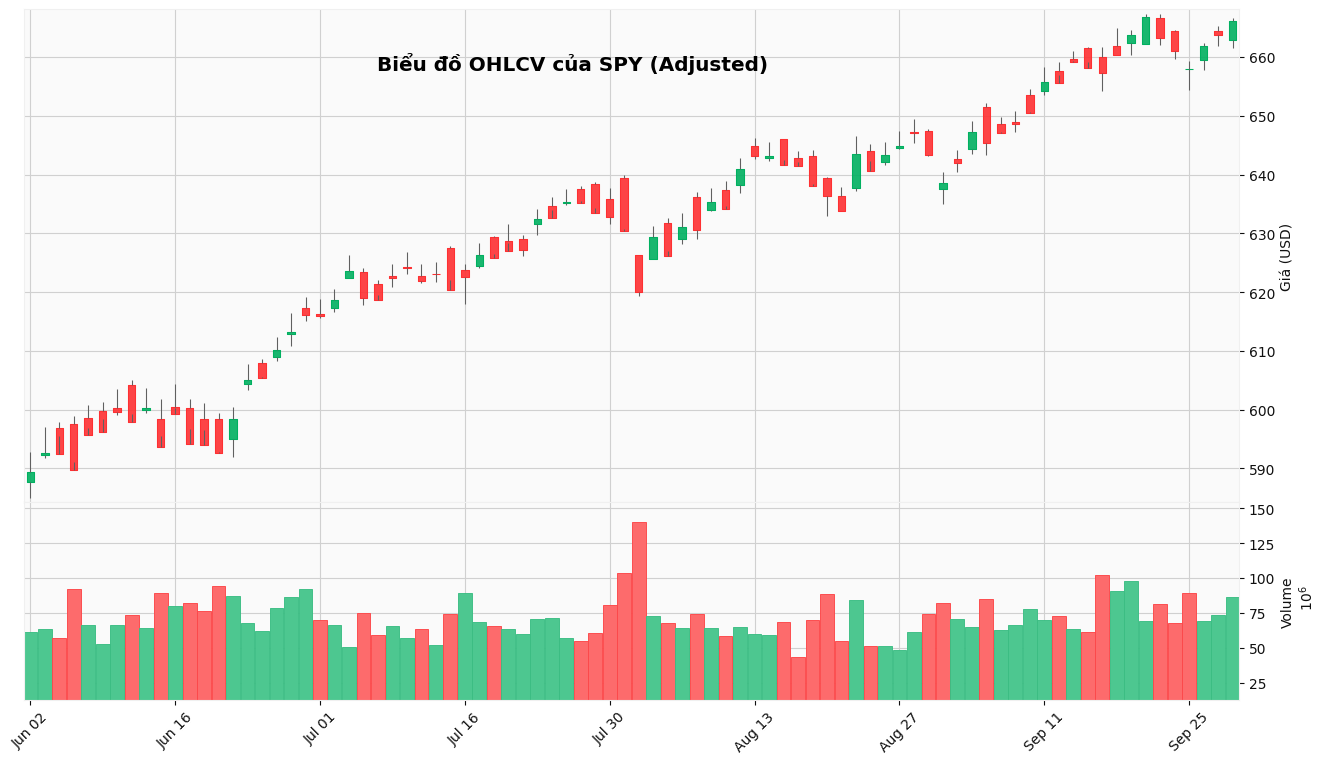

In [10]:
# Thiết lập giao diện (Style)
# 'yahoo': Phong cách giống Yahoo Finance (Nến xanh/đỏ)
my_style = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'font.size': 10})

# Vẽ biểu đồ
# type='candle': Biểu đồ nến
# volume=True: Hiển thị Volume bên dưới
df_short = df.loc['2025-06-01':'2025-10-01']
mpf.plot(df_short,
         type='candle',
         style=my_style,
         title=f'Biểu đồ OHLCV của {ticker} (Adjusted)',
         ylabel='Giá (USD)',
         ylabel_lower='Volume',
         volume=True,
         figsize=(14, 8),
         tight_layout=True)


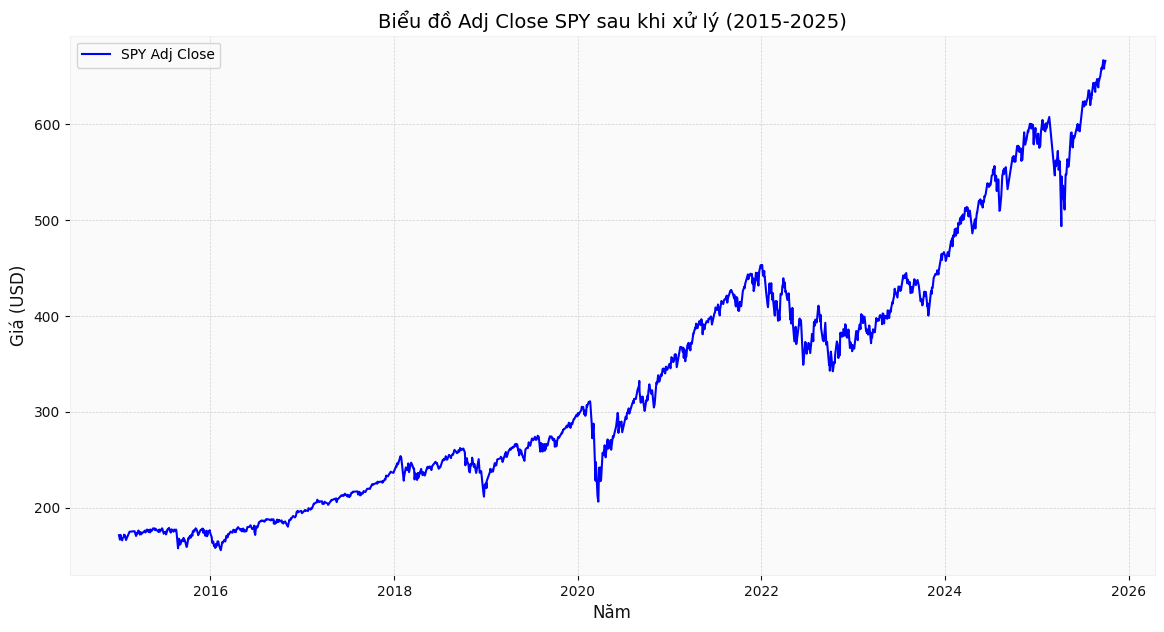

In [15]:
# Vẽ biểu đồ thể hiện Adj Close
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label=f'{ticker} Adj Close', color='blue', linewidth=1.5)

plt.title(f'Biểu đồ Adj Close {ticker} sau khi xử lý (2015-2025)', fontsize=14)
plt.xlabel('Năm', fontsize=12)
plt.ylabel('Giá (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

### Trading Signal

Trading Rules
- Tín hiệu MUA (Long Entry): Khi đường SMA 50 (Ngắn hạn) cắt lên trên đường SMA 200 (Dài hạn). Đây gọi là "Golden Cross", báo hiệu thị trường bước vào xu hướng tăng dài hạn.
- Tín hiệu BÁN/THOÁT (Exit/Short): Khi đường SMA 50 cắt xuống dưới đường SMA 200. Đây gọi là "Death Cross", báo hiệu xu hướng giảm.

In [12]:
def strategy_sma_crossover(data_input):
    """
    Chiến lược Golden Cross: SMA 50 cắt lên SMA 200
    Input: df
    """
    df_sma = data_input.copy()

    # 1. Tính toán SMA50 và SMA200
    df_sma['SMA_50'] = df_sma['close'].rolling(window=50).mean()
    df_sma['SMA_200'] = df_sma['close'].rolling(window=200).mean()

    # 2. Tạo Tín hiệu (Signal)
    # Signal = 1 khi SMA_50 > SMA_200 (Giữ cổ phiếu - Mua cổ phiếu)
    # Signal = 0 khi SMA_50 <= SMA_200 (Giữ tiền mặt - Bán hết cổ phiếu)
    df_sma['Signal'] = 0
    df_sma.loc[df_sma['SMA_50'] > df_sma['SMA_200'], 'Signal'] = 1

    # 3. Tính Lợi nhuận Chiến lược (Strategy Returns)
    # Market Return: Lợi nhuận hàng ngày của cổ phiếu
    df_sma['Market_Return'] = df_sma['close'].pct_change()

    # Strategy Return: Lợi nhuận khi theo tín hiệu
    # shift(1) là quan trọng: Tín hiệu hôm nay dùng để giao dịch cho ngày mai (tránh look-ahead bias)
    df_sma['Strategy_Return'] = df_sma['Signal'].shift(1) * df_sma['Market_Return']

    # 4. Tính Lợi nhuận tích lũy (Cumulative Returns) - Lãi kép
    df_sma['Cumulative_Market'] = (1 + df_sma['Market_Return']).cumprod()
    df_sma['Cumulative_Strategy'] = (1 + df_sma['Strategy_Return']).cumprod()

    return df_sma

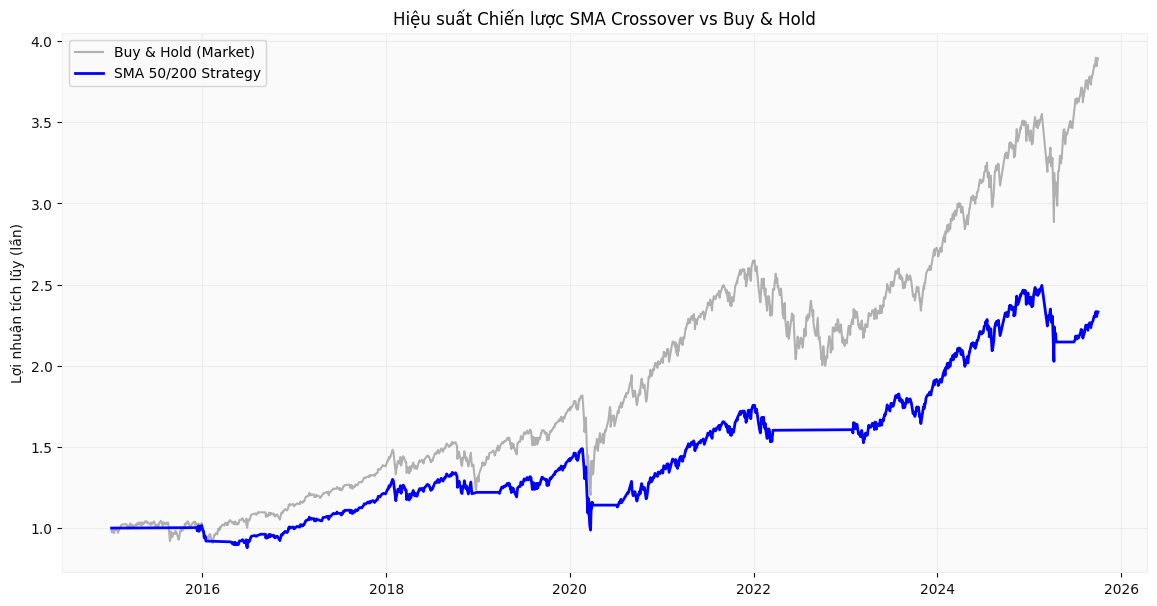

Lợi nhuận Buy & Hold: 289.37%
Lợi nhuận Chiến lược SMA: 133.18%


In [13]:
# --- BACKTEST ---
results = strategy_sma_crossover(df)

# Vẽ biểu đồ so sánh
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['Cumulative_Market'], label='Buy & Hold (Market)', color='gray', alpha=0.6)
plt.plot(results.index, results['Cumulative_Strategy'], label='SMA 50/200 Strategy', color='blue', linewidth=2)

plt.title('Hiệu suất Chiến lược SMA Crossover vs Buy & Hold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylabel('Lợi nhuận tích lũy (lần)')
plt.show()

# In thống kê cuối cùng
total_ret_market = results['Cumulative_Market'].iloc[-1] - 1
total_ret_strategy = results['Cumulative_Strategy'].iloc[-1] - 1
print(f"Lợi nhuận Buy & Hold: {total_ret_market:.2%}")
print(f"Lợi nhuận Chiến lược SMA: {total_ret_strategy:.2%}")

Tại sao Chiến lược chỉ sử dụng SMA không hiệu quả?
- Độ trễ (The Cost of Lag): Khi thị trường đảo chiều tăng mạnh, SMA phản ứng chậm. Bắt đầu mua khi giá đã tăng một đoạn khá xa, bỏ lỡ đoạn lợi nhuận từ đáy.
- Tín hiệu giả (Whipsaws in Sideways Markets): Khi thị trường đi ngang (không rõ xu hướng), giá cứ cắt lên rồi lại cắt xuống liên tục. Bị "mua đỉnh bán đáy" liên tiếp (mua xong giá giảm, bán xong giá tăng), khiến tài khoản bị bào mòn dần bởi các khoản lỗ nhỏ.

Cách khắc khục:
- Chuyển sang EMA (Exponential Moving Average) là bước nâng cấp đầu tiên để khắc phục nhược điểm "trọng số bình đẳng" (equal weighting) của SMA.
- Lý thuyết: EMA gán trọng số lớn hơn cho dữ liệu giá gần nhất, giúp đường trung bình phản ứng nhanh hơn với sự thay đổi của thị trường và giảm bớt độ trễ (lag)
- Formula: $$EMA_{t} = \alpha \times P_{t} + (1 - \alpha) \times EMA_{t-1}$$ với $$\alpha = \frac{2}{N + 1}$$

In [14]:
! git add .
! git commit -m "Update SMA"
! git push


[main 260e16f] Update SMA
 1 file changed, 84 insertions(+), 42 deletions(-)


To https://github.com/tamnguyen-2905/CF_Tam22110193.git
   520cd1f..260e16f  main -> main
